# Final Project: High-dynamic range imaging

### Implement Debevec-Malik method, e.g. see section 10.2 in Szeliski's book for details. You can use examples from here. Once you test your implementation on bracketed image sequences taken on a tripod, you can try to extend your method to multi-exposure images taken without a tripod using homography-based registration of the sequence. Can you drop the assumption that exposure is known?

## Part1 Implement Debevec-Malik method

#### Step 1
Estimate the radiometric response function

In [96]:
%matplotlib notebook

import numpy as np
import random
import numpy.linalg as la
import matplotlib
import matplotlib.image as image
import matplotlib.pyplot as plt
from skimage.feature import (corner_harris, corner_peaks, plot_matches, BRIEF, match_descriptors)
from skimage.transform import warp, ProjectiveTransform, EssentialMatrixTransform, FundamentalMatrixTransform
from skimage.color import rgb2gray
from skimage.measure import ransac

In [97]:
def MySampleIntensities(images,Z_min,Z_max):
    
    num_intensities = Z_max - Z_min + 1
    num_images = len(images)
    SN = 5 # how many sample for each inten
    intensity_values = np.zeros((num_intensities*SN, num_images), dtype=np.uint8)

    # Find the middle image to use as the source for pixel intensity locations
    mid_img = images[num_images // 2]

    k = 0
    for i in range(Z_min, Z_max + 1):
        rows, cols = np.where(mid_img == i)
        if(len(rows)):
            cnt = min(SN, len(rows))
            idxs = np.random.choice(len(rows),cnt,replace=False)
            for i in idxs:
                intensity_values[k] = images[:,rows[i], cols[i]]
                k +=1
    return intensity_values[:k,:]

def gslove(Z,B,l,w,Z_min,Z_max): # Based on Debevec and Malik's 21 line MATLAB
    n = Z_max - Z_min +1
    A = np.zeros((Z.shape[0]*Z.shape[1]+n, Z.shape[0]+n))
    b = np.zeros((A.shape[0],1))
    k = 0 
    # Include the data−fitting equations
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            wij = w[Z[i,j]]
            A[k,Z[i,j]] = wij; A[k,n+i] = -wij; b[k] = wij*B[j]
            k += 1
    # Fix the curve by setting its middle value to 0
    A[k,n//2] = 1
    k+=1
    # Include the smoothness equations
    
    for i in range(n-1):
        A[k,i:i+3] = l * w[i+1] * np.array([1,-2,1])
        k+=1
    print(A.shape)
    # Solve the system
    x = np.linalg.lstsq(A,b)[0]
    print(A.shape,b.shape,x.shape)
    print(k)
    
    g = x[0:n,0]
    lE = x[n:,0]
    
    return (g,lE)

(3, 580, 870, 3)


<IPython.core.display.Javascript object>


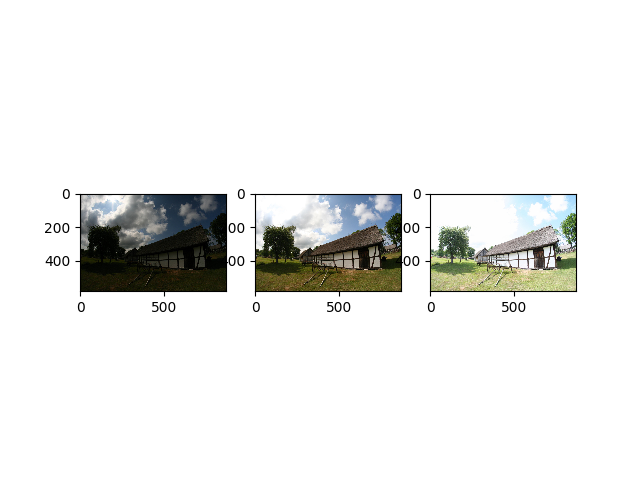

(4096, 1536)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


(4096, 1536) (4096, 1) (1536, 1)
4096


<IPython.core.display.Javascript object>


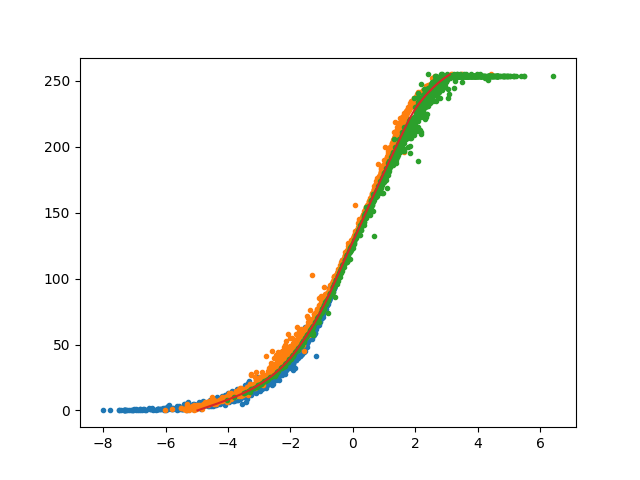

??? (256,)
(4096, 1536)
(4096, 1536) (4096, 1) (1536, 1)
4096


<IPython.core.display.Javascript object>


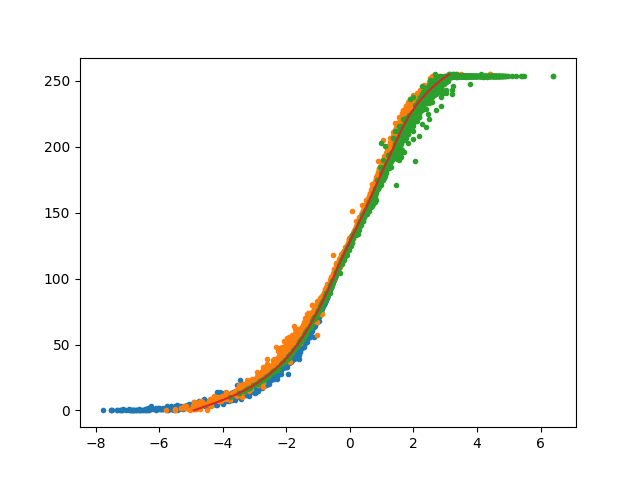

??? (256,)
(4096, 1536)
(4096, 1536) (4096, 1) (1536, 1)
4096


<IPython.core.display.Javascript object>


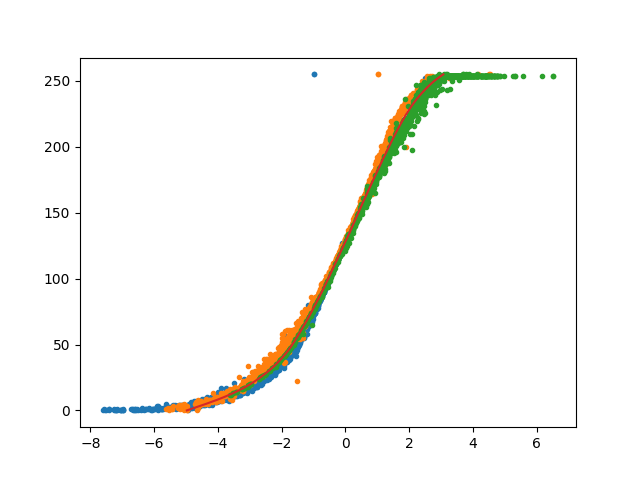

??? (256,)


In [98]:
imgs = np.array([
    image.imread("images/Kluki_-2.jpg"),
    image.imread("images/Kluki_0.jpg"),
    image.imread("images/Kluki_2.jpg"),
])
lT = log_exposure_time = np.array([-2,0,2])

print(imgs.shape)
n = imgs.shape[0]
ih = imgs.shape[1]
iw = imgs.shape[2]
isize = ih * iw
channel = imgs.shape[3]

plt.figure(0)
for i in range(n):
    plt.subplot(1,n,i+1)
    plt.imshow(imgs[i])

z_min = 0
z_max = 255
w = np.array(range(z_max+1))
w = np.minimum(w-z_min, z_max-w)
gs = np.zeros((channel,z_max-z_min+1))

for c in range(channel):
    sample = MySampleIntensities(imgs[:,:,:,0],z_min,z_max)
    g,lE = gslove(sample,log_exposure_time, 128., w, z_min, z_max )
    plt.figure(c+1)
    for j in range(sample.shape[1]):
        plt.plot(lE+log_exposure_time[j],sample[:,j],'.')
    
    plt.plot(g,range(g.shape[0]))
    print('???',g.shape)
    gs[c] = g

plt.show()

### Step2
select pixels and estimate a radiance map

In [119]:
result = np.zeros((ih,iw,channel))

for c in range(channel):
    g = gs[c]

    logE = np.zeros((ih,iw))
    ww = np.exp(g) / np.gradient(g)

    for x in range(ih):
        for y in range(iw):
            logE[x,y] = ((ww[imgs[:,x,y,c]] * g[imgs[:,x,y,c]] - lT)).sum() / ww[imgs[:,x,y,c]].sum()
    result[:,:,c] = logE

### step 3
from $\log E_i$ to image

<IPython.core.display.Javascript object>


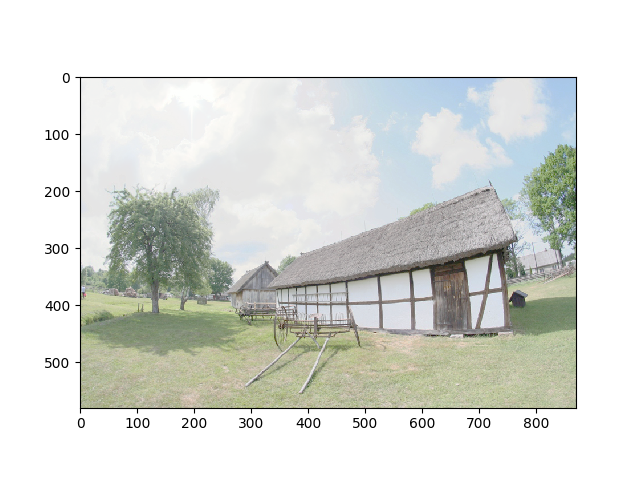

In [132]:
plt.figure(channel+1)

result1 = result - result.min()
result1 *= 255/ result1.max()

plt.imshow(result1.astype(np.uint8))

<IPython.core.display.Javascript object>


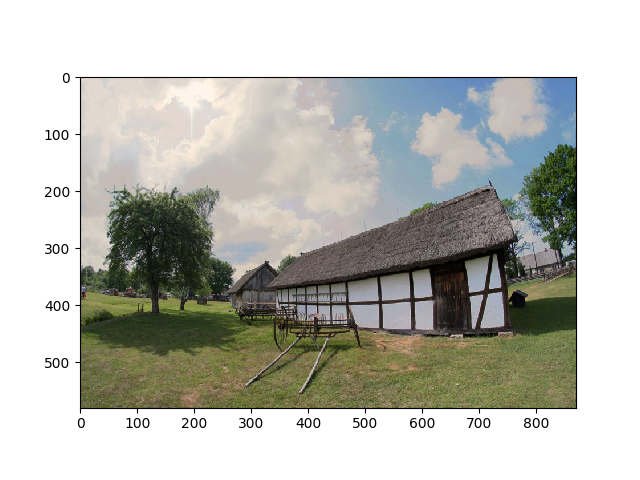

In [140]:
import cv2
gamma = 0.4

result2 = cv2.pow(result1/255., 1.0/gamma)
base_img = imgs[n//2]
for c in range(channel):
    result2[:,:,c] *= base_img[:,:,c].sum() / result2[:,:,c].sum()

result2 = cv2.normalize(result2, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
plt.figure(channel+2)
plt.imshow(result2.astype(np.uint8))
image.imsave('my.jpg',result2.astype(np.uint8))